In [15]:
import csv
import torch
import utils as ut
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric


# File path (replace with the actual file path)
csv_path = "/media/maria/work_space/capsule-3259363/data/HarvardOPV_40.csv" #data/HarvardOPV_40.csv"

# Open the CSV file and process it
harvard_dataset = []
with open(csv_path, newline='', encoding='utf-8') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    
    # Read the header to identify column indices
    header = next(csv_reader)
    smiles_idx = header.index("smiles")
    homo_idx = header.index("homo")
    lumo_idx = header.index("lumo")
    gap_idx = header.index("gap")
    heavy_atoms_idx = header.index("heavy_atoms")
    
    # Read each row
    for row in csv_reader:
        smiles = row[smiles_idx]
        homo = torch.tensor([float(row[homo_idx])], dtype=torch.float) * 27  # Convert from Hartree to eV
        lumo = torch.tensor([float(row[lumo_idx])], dtype=torch.float32) * 27
        gap = torch.tensor([float(row[gap_idx])], dtype=torch.float32) * 27 
        heavy_atoms = torch.tensor([float(row[heavy_atoms_idx])], dtype=torch.float32)

        # Convert SMILES to molecular graph
        graph_data = ut.smiles_to_graph(smiles)
        if graph_data is None:
            continue  # Skip invalid molecules
        
        z, pos = graph_data
        
        # Create a PyTorch Geometric Data object
        data_entry = Data(
            pos=pos.to(torch.float32),    # Atomic positions
            z=torch.LongTensor(z),        # Atomic numbers
            homo = homo.to(torch.float32),
            lumo = lumo.to(torch.float32),
            gap = gap.to(torch.float32),
            heavy_atoms = heavy_atoms.to(torch.float32),
            y=torch.tensor([homo, lumo], dtype=torch.float32),  # Polarizability tensor (target)
        )
        
        harvard_dataset.append(data_entry)



[23:33:44] UFFTYPER: Unrecognized atom type: Se2+2 (4)
[23:33:44] UFFTYPER: Unrecognized atom type: Se2+2 (4)


In [11]:
from rdkit import Chem
import torch
from torch_geometric.data import Data

# https://pytorch-geometric.readthedocs.io/en/2.6.1/generated/torch_geometric.datasets.QM9.html for property numbers
def preprocess_qm9(data):
    """
    Process the QM9 dataset to extract atomic positions, atomic numbers, HOMO, LUMO, gap, 
    and count the number of heavy atoms (non-hydrogen atoms).
    """
    new_dataset = []

    for molecule in data:
        pos = molecule.pos
        z = molecule.z
        homo = molecule.y.squeeze()[2]
        lumo = molecule.y.squeeze()[3]
        gap = molecule.y.squeeze()[4]

        # Count heavy atoms (all non-hydrogen atoms)
        heavy_atoms = (z > 1).sum().item()  

        # Create the dataset entry
        data_entry = Data(
            pos=pos.to(torch.float32),    # Atomic positions
            z=torch.LongTensor(z),        # Atomic numbers
            homo=homo.to(torch.float32),
            lumo=lumo.to(torch.float32),
            gap=gap.to(torch.float32),
            heavy_atoms=torch.tensor(heavy_atoms, dtype=torch.float32),  # Count of heavy atoms
            y=torch.tensor([homo, lumo], dtype=torch.float32)  # HOMO and LUMO values
        )

        new_dataset.append(data_entry)
    
    return new_dataset


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
from torch_geometric.datasets import QM9


path = osp.join('..', 'data', 'QM9')
dataset = QM9(path).shuffle()
qm9_dataset = preprocess_qm9(dataset)


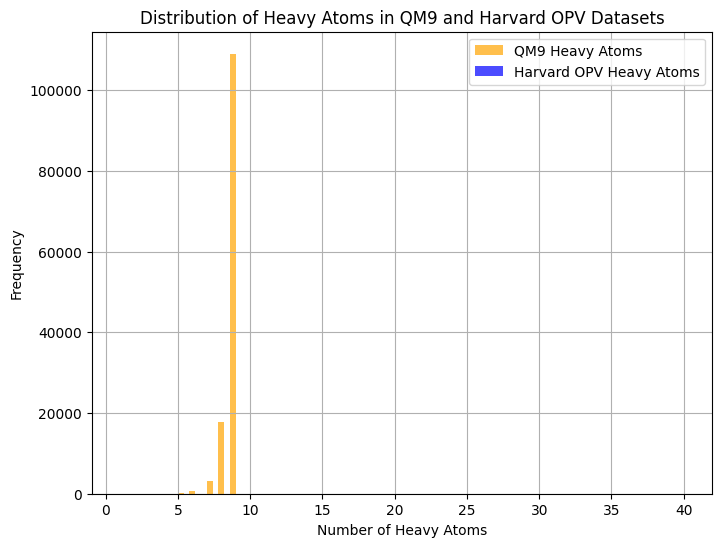

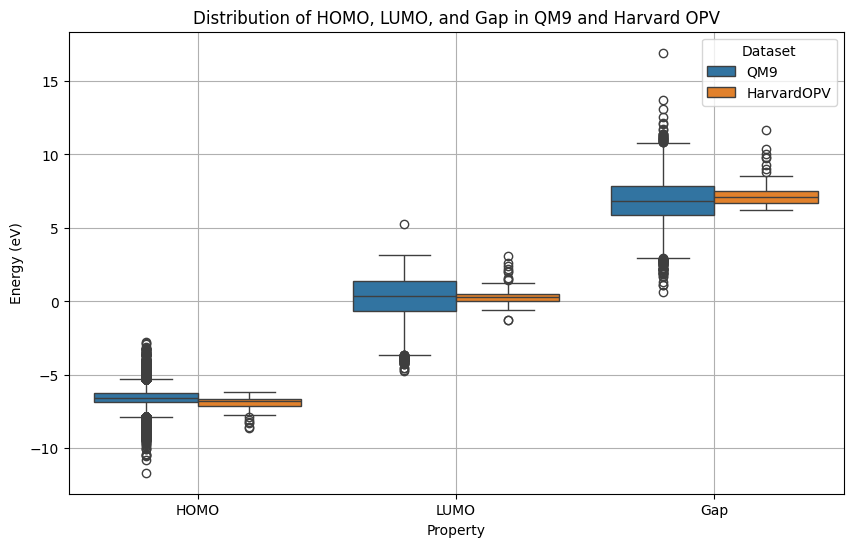

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert data into lists for analysis
qm9_homo = [data.homo.item() for data in qm9_dataset]
qm9_lumo = [data.lumo.item() for data in qm9_dataset]
qm9_gap = [data.gap.item() for data in qm9_dataset]
qm9_heavy_atoms = [data.heavy_atoms.item() for data in qm9_dataset]

harvard_homo = [data.homo.item() for data in harvard_dataset]
harvard_lumo = [data.lumo.item() for data in harvard_dataset]
harvard_gap = [data.gap.item() for data in harvard_dataset]
harvard_heavy_atoms = [data.heavy_atoms.item() for data in harvard_dataset]

# Create a dataframe for boxplot visualization
df = pd.DataFrame({
    'Dataset': ['QM9'] * len(qm9_homo) + ['HarvardOPV'] * len(harvard_homo),
    'HOMO': qm9_homo + harvard_homo,
    'LUMO': qm9_lumo + harvard_lumo,
    'Gap': qm9_gap + harvard_gap
})

# Plot the heavy atom distribution as a histogram
plt.figure(figsize=(8, 6))
plt.hist(qm9_heavy_atoms, bins=20, alpha=0.7, color='orange', label='QM9 Heavy Atoms')
plt.hist(harvard_heavy_atoms, bins=20, alpha=0.7, color='blue', label='Harvard OPV Heavy Atoms')
plt.xlabel('Number of Heavy Atoms')
plt.ylabel('Frequency')
plt.title('Distribution of Heavy Atoms in QM9 and Harvard OPV Datasets')
plt.legend()
plt.grid(True)
plt.show()

# Boxplots for HOMO, LUMO, and Gap
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.melt(id_vars=['Dataset'], var_name='Property', value_name='Energy (eV)'), 
            x='Property', y='Energy (eV)', hue='Dataset')
plt.title('Distribution of HOMO, LUMO, and Gap in QM9 and Harvard OPV')
plt.grid(True)
plt.show()


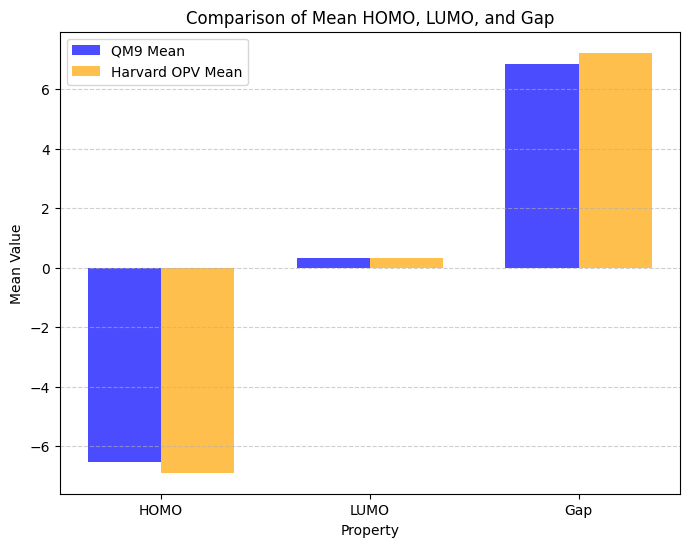

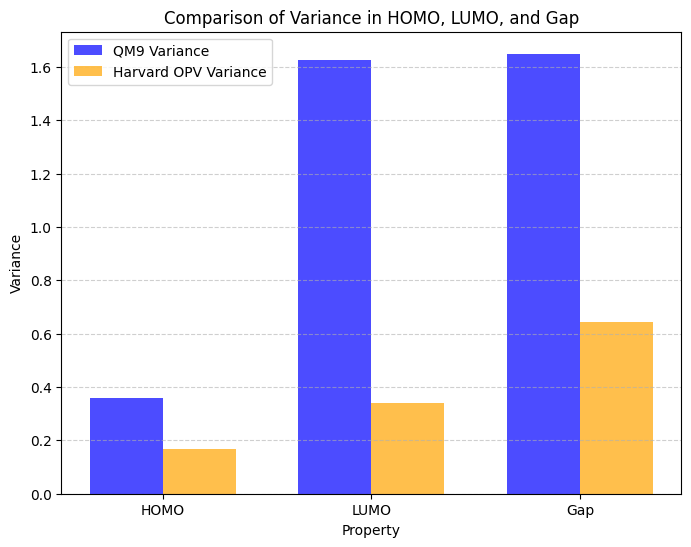

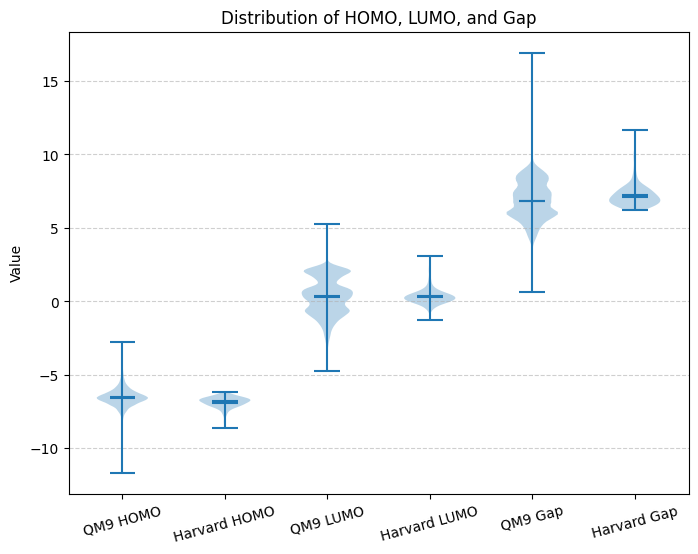

/tmp/ipykernel_23917/2685781481.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_violin, labels=labels_violin, showmeans=True)


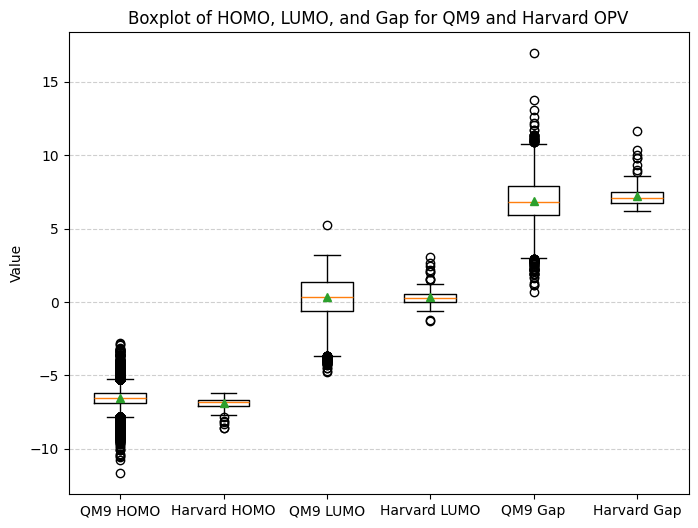

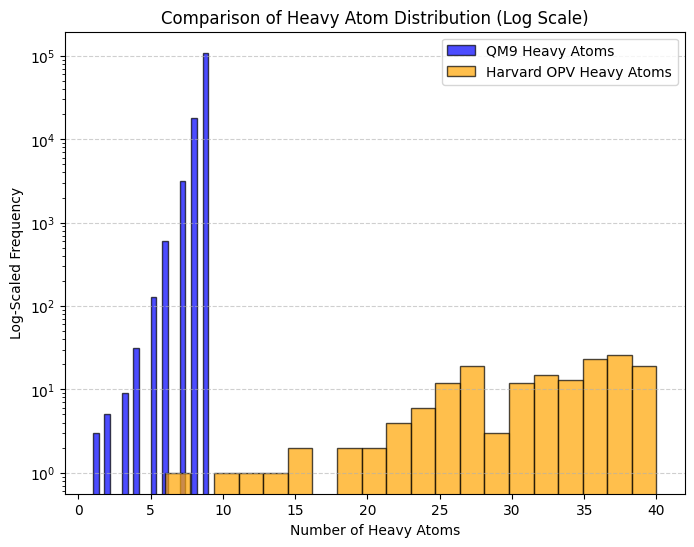

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Extract relevant data for visualization
qm9_homo = [data.homo.item() for data in qm9_dataset]
qm9_lumo = [data.lumo.item() for data in qm9_dataset]
qm9_gap = [data.gap.item() for data in qm9_dataset]
qm9_heavy_atoms = [data.heavy_atoms.item() for data in qm9_dataset]

harvard_homo = [data.homo.item() for data in harvard_dataset]
harvard_lumo = [data.lumo.item() for data in harvard_dataset]
harvard_gap = [data.gap.item() for data in harvard_dataset]
harvard_heavy_atoms = [data.heavy_atoms.item() for data in harvard_dataset]

# Calculate mean and variance
qm9_mean_homo = np.mean(qm9_homo)
qm9_mean_lumo = np.mean(qm9_lumo)
qm9_mean_gap = np.mean(qm9_gap)

harvard_mean_homo = np.mean(harvard_homo)
harvard_mean_lumo = np.mean(harvard_lumo)
harvard_mean_gap = np.mean(harvard_gap)

qm9_variance_homo = np.var(qm9_homo)
qm9_variance_lumo = np.var(qm9_lumo)
qm9_variance_gap = np.var(qm9_gap)

harvard_variance_homo = np.var(harvard_homo)
harvard_variance_lumo = np.var(harvard_lumo)
harvard_variance_gap = np.var(harvard_gap)

# Categories for plotting
categories = ['HOMO', 'LUMO', 'Gap']
qm9_means = [qm9_mean_homo, qm9_mean_lumo, qm9_mean_gap]
harvard_means = [harvard_mean_homo, harvard_mean_lumo, harvard_mean_gap]

qm9_variances = [qm9_variance_homo, qm9_variance_lumo, qm9_variance_gap]
harvard_variances = [harvard_variance_homo, harvard_variance_lumo, harvard_variance_gap]

x = np.arange(len(categories))
width = 0.35  # Width of bars in grouped bar chart

# **1. Bar Chart for Mean Comparison**
plt.figure(figsize=(8, 6))
plt.bar(x - width/2, qm9_means, width, label='QM9 Mean', color='blue', alpha=0.7)
plt.bar(x + width/2, harvard_means, width, label='Harvard OPV Mean', color='orange', alpha=0.7)
plt.xlabel('Property')
plt.ylabel('Mean Value')
plt.title('Comparison of Mean HOMO, LUMO, and Gap')
plt.xticks(x, categories)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# **2. Bar Chart for Variance Comparison**
plt.figure(figsize=(8, 6))
plt.bar(x - width/2, qm9_variances, width, label='QM9 Variance', color='blue', alpha=0.7)
plt.bar(x + width/2, harvard_variances, width, label='Harvard OPV Variance', color='orange', alpha=0.7)
plt.xlabel('Property')
plt.ylabel('Variance')
plt.title('Comparison of Variance in HOMO, LUMO, and Gap')
plt.xticks(x, categories)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# **3. Violin Plot for Distribution**
plt.figure(figsize=(8, 6))
data_violin = [qm9_homo, harvard_homo, qm9_lumo, harvard_lumo, qm9_gap, harvard_gap]
labels_violin = ['QM9 HOMO', 'Harvard HOMO', 'QM9 LUMO', 'Harvard LUMO', 'QM9 Gap', 'Harvard Gap']
plt.violinplot(data_violin, showmeans=True, showmedians=True)
plt.xticks(np.arange(1, len(labels_violin) + 1), labels_violin, rotation=15)
plt.ylabel('Value')
plt.title('Distribution of HOMO, LUMO, and Gap')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# **4. Box Plot for Spread of Data**
plt.figure(figsize=(8, 6))
plt.boxplot(data_violin, labels=labels_violin, showmeans=True)
plt.ylabel('Value')
plt.title('Boxplot of HOMO, LUMO, and Gap for QM9 and Harvard OPV')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# **5. Histogram for Heavy Atom Distribution with Log Scale**
plt.figure(figsize=(8, 6))

# Plot histogram with log scale
plt.hist(qm9_heavy_atoms, bins=20, alpha=0.7, color='blue', label='QM9 Heavy Atoms', edgecolor='black', log=True)
plt.hist(harvard_heavy_atoms, bins=20, alpha=0.7, color='orange', label='Harvard OPV Heavy Atoms', edgecolor='black', log=True)

plt.xlabel('Number of Heavy Atoms')
plt.ylabel('Log-Scaled Frequency')
plt.title('Comparison of Heavy Atom Distribution (Log Scale)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
